# EfficientNet Furniture Classification Experiments

This notebook trains EfficientNetB0 on furniture profitability classification with three data configurations:
- **all**: All data in dataset
- **high_quality**: High confidence predictions (≥0.8 confidence score for any tabular column)
- **brand_msrp_only**: Only listings with known brand and MSRP data

In [2]:
# Login to HuggingFace to access private dataset
from huggingface_hub import login
login()

In [3]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
import pandas as pd
from pathlib import Path

from experiments.dataset_utils import load_and_split_hf_data, get_hf_data_loaders, DATASET_REPO
from experiments.training_utils import (
    train_model, evaluate_model, plot_training_history, 
    plot_confusion_matrix, visualize_misclassified,
    save_experiment_results, print_experiment_summary
)

# Set random seeds for reproducability across experiments
torch.manual_seed(42)
np.random.seed(42)

# Device config
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    print(f"Using device: CPU")

# Paths
RESULTS_DIR = Path('results/efficientnet')
MODELS_DIR = Path('models/efficientnet')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using HuggingFace dataset: {DATASET_REPO}")

Using device: CUDA - Tesla V100-SXM2-16GB
Using HuggingFace dataset: adybacki/furniture-profitability-dataset


## Data Transforms

In [4]:
# EfficientNetB0 expects 224x224 images with ImageNet normalization
IMAGE_SIZE = 224
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

## Model Definition

In [5]:
def create_efficientnet_model():
    """
    Create EfficientNetB0 model for binary classification
    """
    # Load pre-trained EfficientNetB0
    model = models.efficientnet_b0(pretrained=True)
    
    # Freeze backbone
    for param in model.features.parameters():
        param.requires_grad = False
    
    # EfficientNetB0 outputs 1280 features
    num_features = model.classifier[1].in_features  # 1280
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)
    )
    
    return model

## Training Configuration

In [6]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001

# Data modes to test
DATA_MODES = ['all', 'high_quality', 'brand_msrp_only']

## Experiment Loop

Run experiments for all three data configurations


EXPERIMENT: EfficientNetB0 with ALL data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: all
26,554 samples after filtering

Original class distribution: {0: 18078, 1: 8476}
Balancing classes to 8476 samples each...
Balanced class distribution: {0: 8476, 1: 8476}

Train samples: 13561
Validation samples: 1695
Test samples: 1696
Dataset initialized with 13561 samples
Class distribution: {1: 6781, 0: 6780}
Dataset initialized with 1695 samples
Class distribution: {0: 848, 1: 847}
Dataset initialized with 1696 samples
Class distribution: {0: 848, 1: 848}


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training efficientnet_all



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 62.98s
────────────────────────────────────────────────────────────
Train - Loss: 0.6923 | Acc: 0.5278 | F1: 0.5290
Val   - Loss: 0.6825 | Acc: 0.5799 | F1: 0.5777
New best model saved (F1: 0.5777)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 62.23s
────────────────────────────────────────────────────────────
Train - Loss: 0.6847 | Acc: 0.5511 | F1: 0.5487
Val   - Loss: 0.6810 | Acc: 0.5794 | F1: 0.6152
New best model saved (F1: 0.6152)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 62.21s
────────────────────────────────────────────────────────────
Train - Loss: 0.6817 | Acc: 0.5642 | F1: 0.5720
Val   - Loss: 0.6771 | Acc: 0.5876 | F1: 0.6066
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 62.52s
────────────────────────────────────────────────────────────
Train - Loss: 0.6774 | Acc: 0.5713 | F1: 0.5673
Val   - Loss: 0.6765 | Acc: 0.5799 | F1: 0.6241
New best model saved (F1: 0.6241)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 62.88s
────────────────────────────────────────────────────────────
Train - Loss: 0.6781 | Acc: 0.5722 | F1: 0.5736
Val   - Loss: 0.6744 | Acc: 0.5835 | F1: 0.5862
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 62.54s
────────────────────────────────────────────────────────────
Train - Loss: 0.6725 | Acc: 0.5829 | F1: 0.5806
Val   - Loss: 0.6746 | Acc: 0.5770 | F1: 0.5839
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 62.46s
────────────────────────────────────────────────────────────
Train - Loss: 0.6734 | Acc: 0.5806 | F1: 0.5804
Val   - Loss: 0.6742 | Acc: 0.5805 | F1: 0.5893
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 62.46s
────────────────────────────────────────────────────────────
Train - Loss: 0.6712 | Acc: 0.5802 | F1: 0.5736
Val   - Loss: 0.6722 | Acc: 0.5764 | F1: 0.5664
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 62.69s
────────────────────────────────────────────────────────────
Train - Loss: 0.6725 | Acc: 0.5820 | F1: 0.5812
Val   - Loss: 0.6709 | Acc: 0.5935 | F1: 0.5765
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 62.18s
────────────────────────────────────────────────────────────
Train - Loss: 0.6704 | Acc: 0.5854 | F1: 0.5861
Val   - Loss: 0.6709 | Acc: 0.5959 | F1: 0.6029
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 61.84s
────────────────────────────────────────────────────────────
Train - Loss: 0.6681 | Acc: 0.5883 | F1: 0.5892
Val   - Loss: 0.6724 | Acc: 0.5817 | F1: 0.5572
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 61.85s
────────────────────────────────────────────────────────────
Train - Loss: 0.6692 | Acc: 0.5860 | F1: 0.5801
Val   - Loss: 0.6680 | Acc: 0.5965 | F1: 0.6131
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 62.05s
────────────────────────────────────────────────────────────
Train - Loss: 0.6682 | Acc: 0.5854 | F1: 0.5841
Val   - Loss: 0.6676 | Acc: 0.5912 | F1: 0.5787
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 62.00s
────────────────────────────────────────────────────────────
Train - Loss: 0.6682 | Acc: 0.5904 | F1: 0.5880
Val   - Loss: 0.6702 | Acc: 0.5971 | F1: 0.6237
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 61.60s
────────────────────────────────────────────────────────────
Train - Loss: 0.6673 | Acc: 0.5904 | F1: 0.5925
Val   - Loss: 0.6714 | Acc: 0.5876 | F1: 0.5776
────────────────────────────────────────────────────────────

TRAINING COMPLETE - efficientnet_all
Best Validation F1: 0.6241
Total Epochs: 15


EXPERIMENT SUMMARY
Model: EfficientNetB0
Data Mode: all

Test Set Performance:
  Accuracy:  0.5784
  F1 Score:  0.6301
  Precision: 0.5613
  Recall:    0.7182



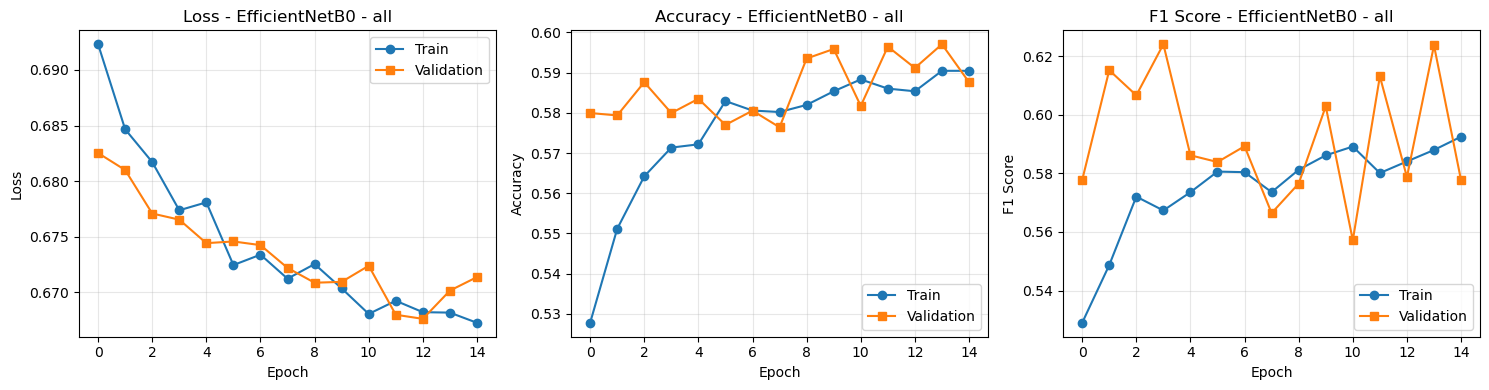

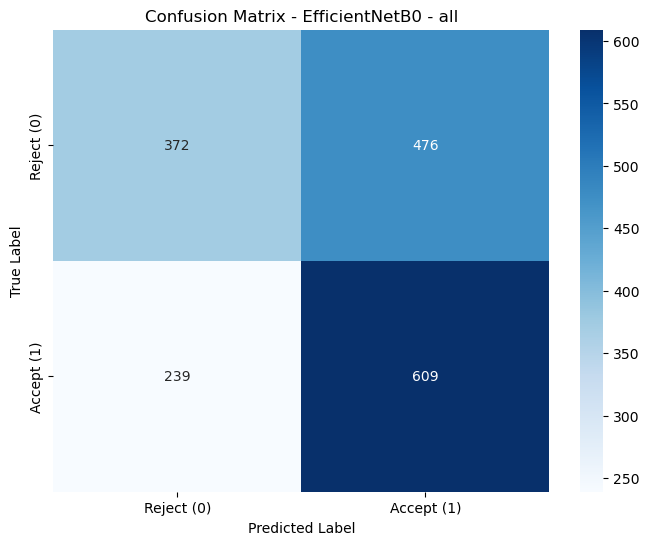


Analyzing misclassified examples...


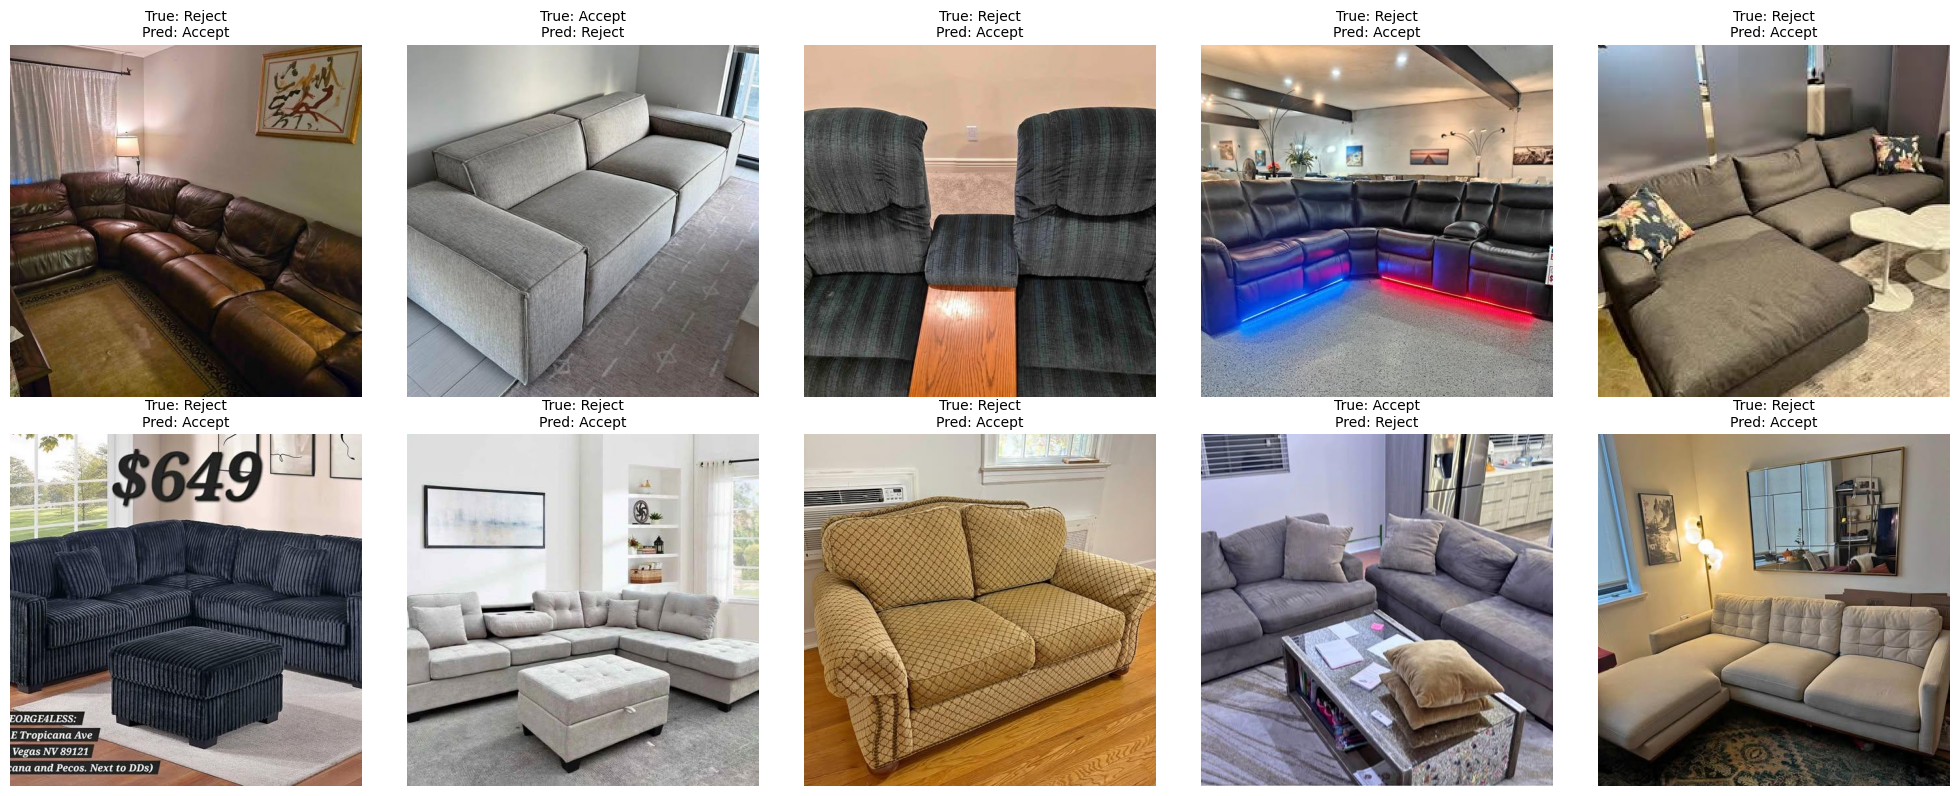

Results saved to results/efficientnet/efficientnet_all_results.json

EXPERIMENT: EfficientNetB0 with HIGH_QUALITY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: high_quality
12,846 samples after filtering

Original class distribution: {0: 6437, 1: 6409}

Train samples: 10276
Validation samples: 1285
Test samples: 1285
Dataset initialized with 10276 samples
Class distribution: {0: 5149, 1: 5127}
Dataset initialized with 1285 samples
Class distribution: {0: 644, 1: 641}
Dataset initialized with 1285 samples


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class distribution: {0: 644, 1: 641}

Training efficientnet_high_quality



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 46.65s
────────────────────────────────────────────────────────────
Train - Loss: 0.6915 | Acc: 0.5316 | F1: 0.5490
Val   - Loss: 0.6822 | Acc: 0.5829 | F1: 0.5677
New best model saved (F1: 0.5677)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 47.56s
────────────────────────────────────────────────────────────
Train - Loss: 0.6820 | Acc: 0.5617 | F1: 0.5578
Val   - Loss: 0.6723 | Acc: 0.5992 | F1: 0.6460
New best model saved (F1: 0.6460)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 47.52s
────────────────────────────────────────────────────────────
Train - Loss: 0.6766 | Acc: 0.5780 | F1: 0.5852
Val   - Loss: 0.6699 | Acc: 0.6086 | F1: 0.6098
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 47.52s
────────────────────────────────────────────────────────────
Train - Loss: 0.6717 | Acc: 0.5848 | F1: 0.5846
Val   - Loss: 0.6686 | Acc: 0.5992 | F1: 0.5986
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 47.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.6703 | Acc: 0.5860 | F1: 0.5853
Val   - Loss: 0.6650 | Acc: 0.6125 | F1: 0.6433
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 47.51s
────────────────────────────────────────────────────────────
Train - Loss: 0.6664 | Acc: 0.5930 | F1: 0.5925
Val   - Loss: 0.6643 | Acc: 0.5977 | F1: 0.5887
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 47.49s
────────────────────────────────────────────────────────────
Train - Loss: 0.6658 | Acc: 0.5926 | F1: 0.5970
Val   - Loss: 0.6618 | Acc: 0.6140 | F1: 0.6101
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 47.48s
────────────────────────────────────────────────────────────
Train - Loss: 0.6625 | Acc: 0.5961 | F1: 0.5933
Val   - Loss: 0.6603 | Acc: 0.6233 | F1: 0.6305
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 47.55s
────────────────────────────────────────────────────────────
Train - Loss: 0.6643 | Acc: 0.5935 | F1: 0.5964
Val   - Loss: 0.6645 | Acc: 0.6093 | F1: 0.6203
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 47.48s
────────────────────────────────────────────────────────────
Train - Loss: 0.6638 | Acc: 0.5928 | F1: 0.5985
Val   - Loss: 0.6603 | Acc: 0.6117 | F1: 0.6392
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 47.49s
────────────────────────────────────────────────────────────
Train - Loss: 0.6594 | Acc: 0.6011 | F1: 0.6076
Val   - Loss: 0.6636 | Acc: 0.6039 | F1: 0.5865
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 47.47s
────────────────────────────────────────────────────────────
Train - Loss: 0.6609 | Acc: 0.6000 | F1: 0.6075
Val   - Loss: 0.6557 | Acc: 0.6132 | F1: 0.6305
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 47.30s
────────────────────────────────────────────────────────────
Train - Loss: 0.6608 | Acc: 0.5989 | F1: 0.6068
Val   - Loss: 0.6593 | Acc: 0.6101 | F1: 0.6324
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 47.24s
────────────────────────────────────────────────────────────
Train - Loss: 0.6582 | Acc: 0.6032 | F1: 0.6128
Val   - Loss: 0.6579 | Acc: 0.6218 | F1: 0.6244
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 47.27s
────────────────────────────────────────────────────────────
Train - Loss: 0.6592 | Acc: 0.5995 | F1: 0.6125
Val   - Loss: 0.6558 | Acc: 0.6210 | F1: 0.6401
────────────────────────────────────────────────────────────

TRAINING COMPLETE - efficientnet_high_quality
Best Validation F1: 0.6460
Total Epochs: 15


EXPERIMENT SUMMARY
Model: EfficientNetB0
Data Mode: high_quality

Test Set Performance:
  Accuracy:  0.5860
  F1 Score:  0.6346
  Precision: 0.5669
  Recall:    0.7207



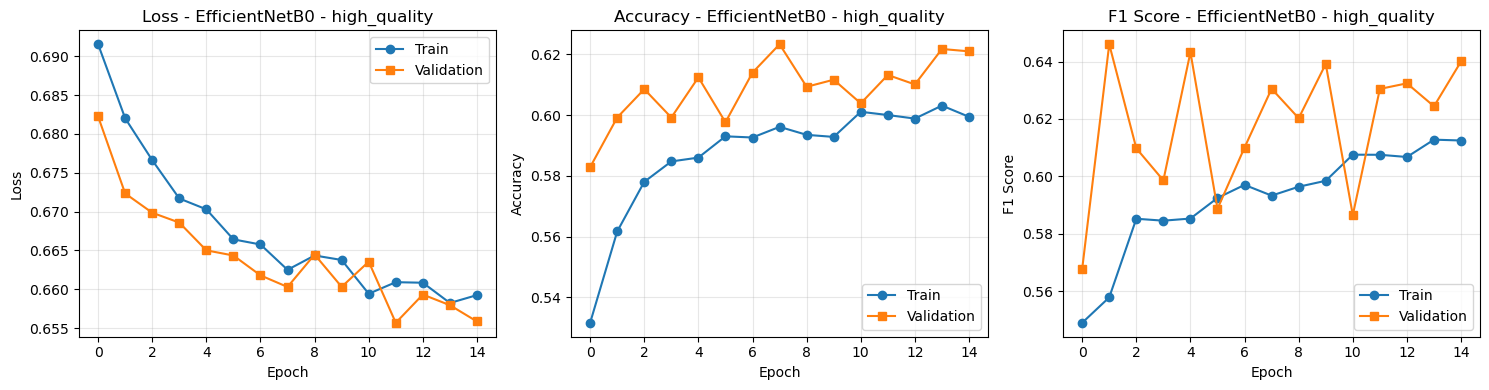

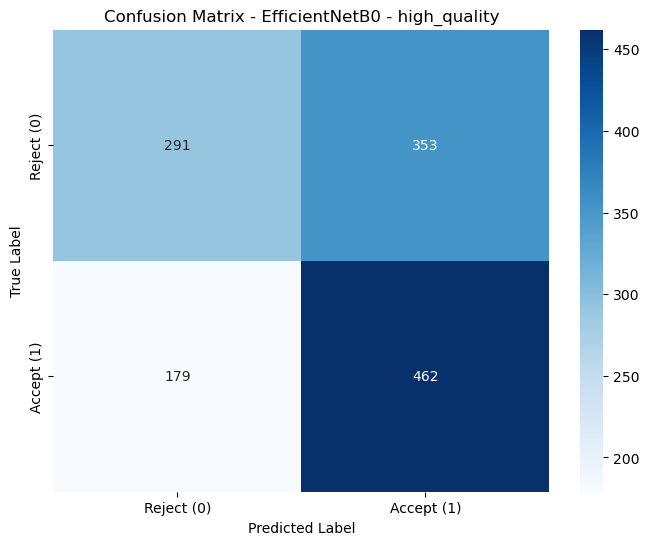


Analyzing misclassified examples...


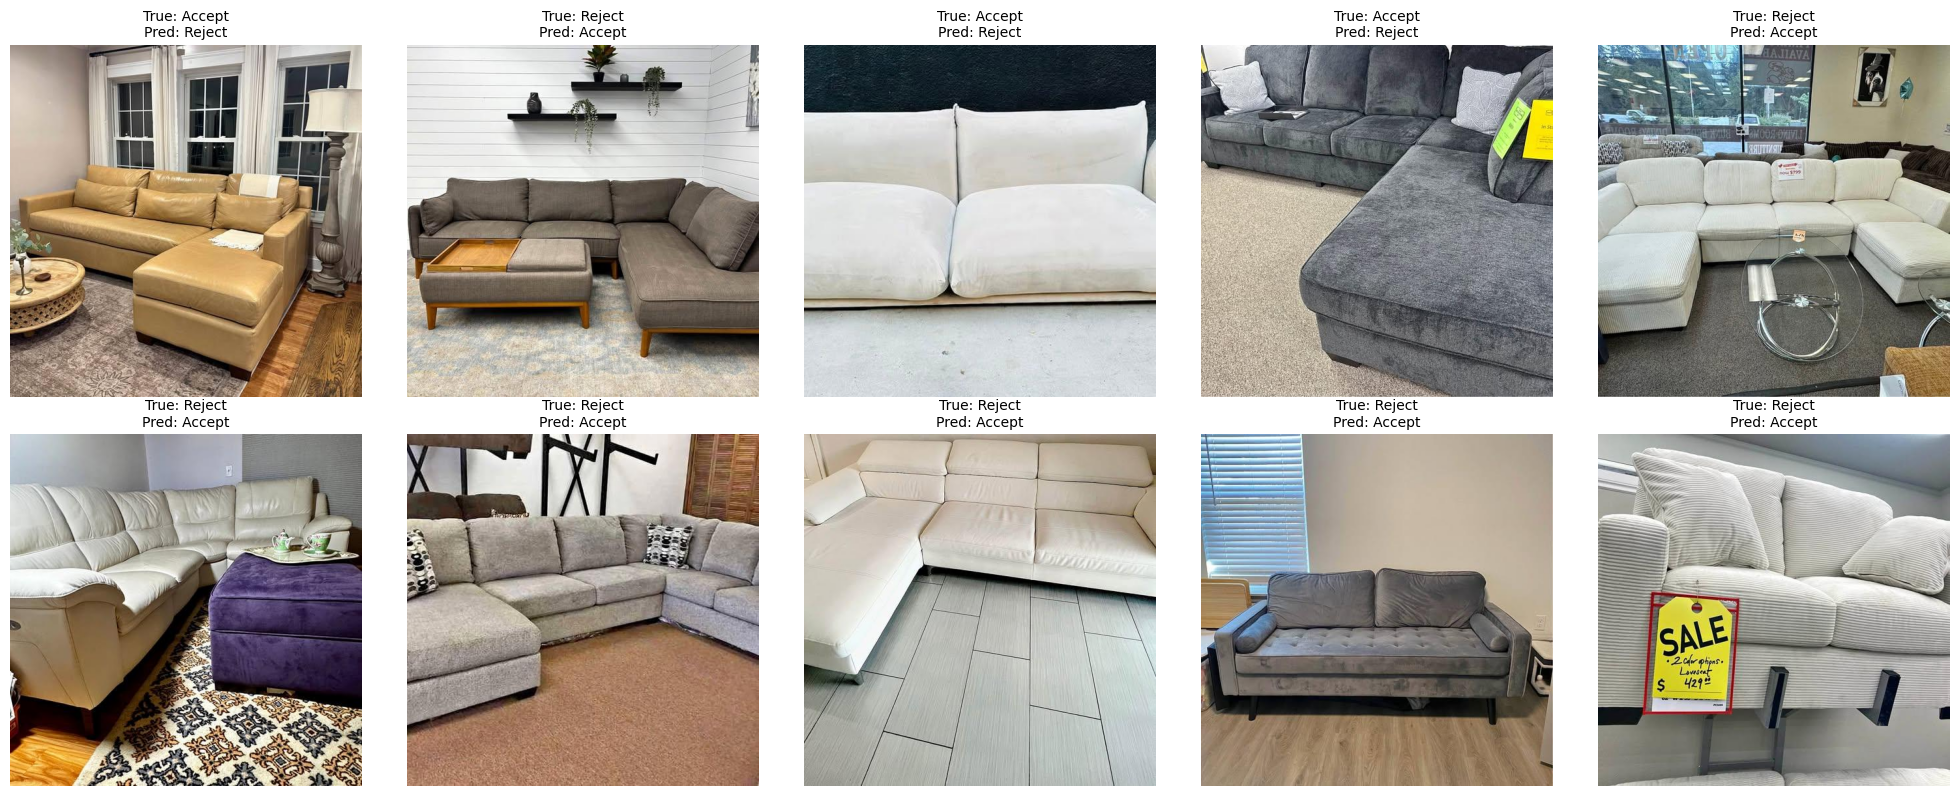

Results saved to results/efficientnet/efficientnet_high_quality_results.json

EXPERIMENT: EfficientNetB0 with BRAND_MSRP_ONLY data

Loading dataset from HuggingFace: adybacki/furniture-profitability-dataset
Loaded 26,554 total samples

Filtering for data_mode: brand_msrp_only
5,209 samples after filtering

Original class distribution: {1: 3499, 0: 1710}
Balancing classes to 1710 samples each...
Balanced class distribution: {1: 1710, 0: 1710}

Train samples: 2736
Validation samples: 342
Test samples: 342
Dataset initialized with 2736 samples
Class distribution: {0: 1368, 1: 1368}
Dataset initialized with 342 samples
Class distribution: {0: 171, 1: 171}
Dataset initialized with 342 samples


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-pyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class distribution: {1: 171, 0: 171}

Training efficientnet_brand_msrp_only



────────────────────────────────────────────────────────────
EPOCH 1/15 COMPLETE - Time: 12.66s
────────────────────────────────────────────────────────────
Train - Loss: 0.6954 | Acc: 0.5099 | F1: 0.5195
Val   - Loss: 0.6905 | Acc: 0.5292 | F1: 0.5796
New best model saved (F1: 0.5796)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 2/15 COMPLETE - Time: 12.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.6823 | Acc: 0.5581 | F1: 0.5786
Val   - Loss: 0.6805 | Acc: 0.5702 | F1: 0.6182
New best model saved (F1: 0.6182)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 3/15 COMPLETE - Time: 12.63s
────────────────────────────────────────────────────────────
Train - Loss: 0.6784 | Acc: 0.5793 | F1: 0.6021
Val   - Loss: 0.6719 | Acc: 0.6082 | F1: 0.6105
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 4/15 COMPLETE - Time: 12.55s
────────────────────────────────────────────────────────────
Train - Loss: 0.6663 | Acc: 0.6100 | F1: 0.6104
Val   - Loss: 0.6726 | Acc: 0.5906 | F1: 0.6535
New best model saved (F1: 0.6535)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 5/15 COMPLETE - Time: 12.58s
────────────────────────────────────────────────────────────
Train - Loss: 0.6573 | Acc: 0.6224 | F1: 0.6379
Val   - Loss: 0.6675 | Acc: 0.6111 | F1: 0.6491
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 6/15 COMPLETE - Time: 12.56s
────────────────────────────────────────────────────────────
Train - Loss: 0.6601 | Acc: 0.6012 | F1: 0.6034
Val   - Loss: 0.6654 | Acc: 0.5994 | F1: 0.6287
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 7/15 COMPLETE - Time: 12.59s
────────────────────────────────────────────────────────────
Train - Loss: 0.6517 | Acc: 0.6181 | F1: 0.6229
Val   - Loss: 0.6678 | Acc: 0.6082 | F1: 0.6492
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 8/15 COMPLETE - Time: 12.63s
────────────────────────────────────────────────────────────
Train - Loss: 0.6546 | Acc: 0.6060 | F1: 0.6172
Val   - Loss: 0.6640 | Acc: 0.6082 | F1: 0.6359
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 9/15 COMPLETE - Time: 12.55s
────────────────────────────────────────────────────────────
Train - Loss: 0.6469 | Acc: 0.6301 | F1: 0.6288
Val   - Loss: 0.6488 | Acc: 0.6287 | F1: 0.6340
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 10/15 COMPLETE - Time: 12.57s
────────────────────────────────────────────────────────────
Train - Loss: 0.6441 | Acc: 0.6327 | F1: 0.6347
Val   - Loss: 0.6597 | Acc: 0.6257 | F1: 0.6701
New best model saved (F1: 0.6701)
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 11/15 COMPLETE - Time: 12.52s
────────────────────────────────────────────────────────────
Train - Loss: 0.6401 | Acc: 0.6312 | F1: 0.6372
Val   - Loss: 0.6511 | Acc: 0.6140 | F1: 0.6471
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 12/15 COMPLETE - Time: 12.56s
────────────────────────────────────────────────────────────
Train - Loss: 0.6368 | Acc: 0.6374 | F1: 0.6465
Val   - Loss: 0.6577 | Acc: 0.6228 | F1: 0.6446
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 13/15 COMPLETE - Time: 12.50s
────────────────────────────────────────────────────────────
Train - Loss: 0.6410 | Acc: 0.6385 | F1: 0.6389
Val   - Loss: 0.6485 | Acc: 0.6257 | F1: 0.6464
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 14/15 COMPLETE - Time: 12.51s
────────────────────────────────────────────────────────────
Train - Loss: 0.6364 | Acc: 0.6371 | F1: 0.6522
Val   - Loss: 0.6446 | Acc: 0.6550 | F1: 0.6685
────────────────────────────────────────────────────────────



────────────────────────────────────────────────────────────
EPOCH 15/15 COMPLETE - Time: 12.52s
────────────────────────────────────────────────────────────
Train - Loss: 0.6264 | Acc: 0.6425 | F1: 0.6477
Val   - Loss: 0.6608 | Acc: 0.6023 | F1: 0.6495
────────────────────────────────────────────────────────────

TRAINING COMPLETE - efficientnet_brand_msrp_only
Best Validation F1: 0.6701
Total Epochs: 15


EXPERIMENT SUMMARY
Model: EfficientNetB0
Data Mode: brand_msrp_only

Test Set Performance:
  Accuracy:  0.6316
  F1 Score:  0.6595
  Precision: 0.6131
  Recall:    0.7135



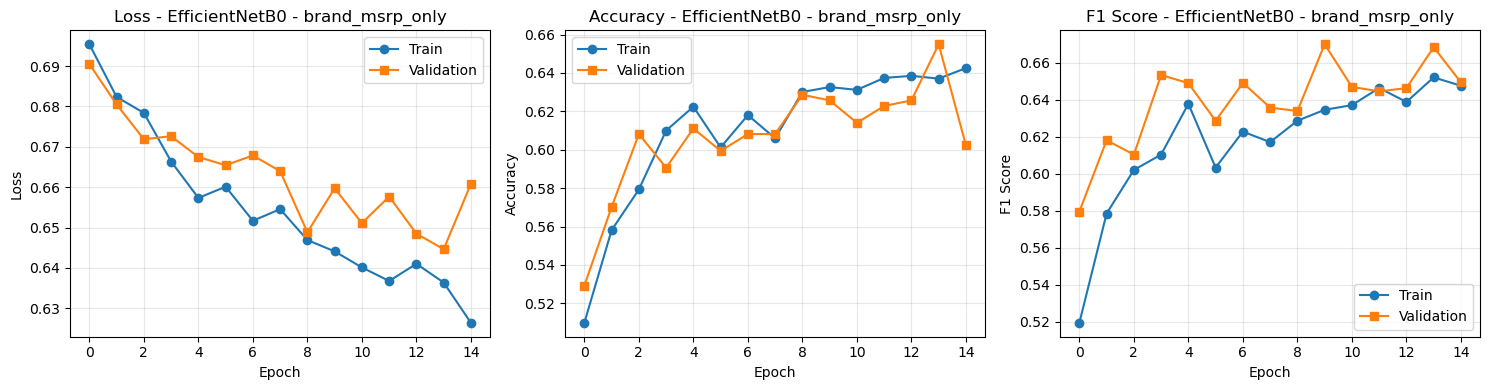

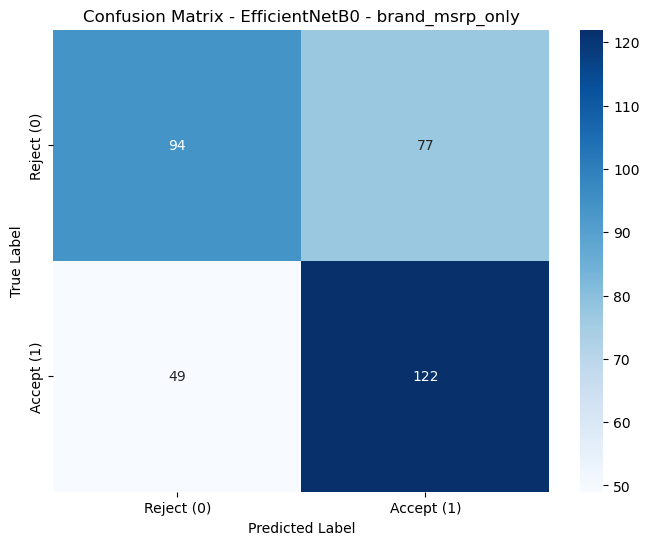


Analyzing misclassified examples...


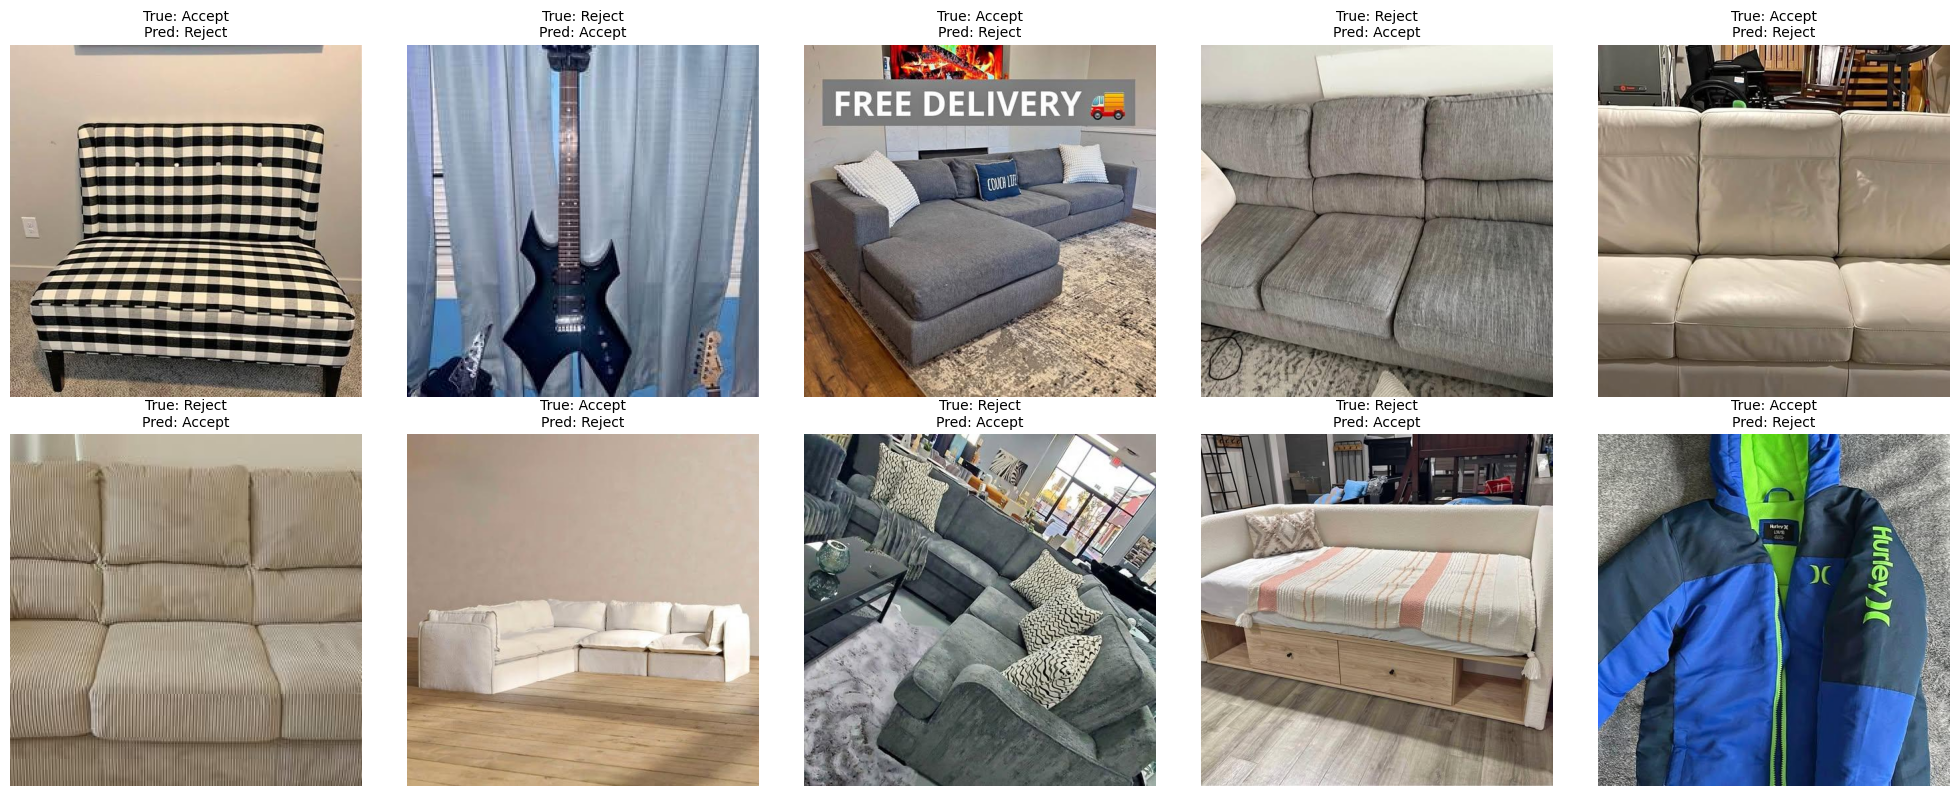

Results saved to results/efficientnet/efficientnet_brand_msrp_only_results.json


In [7]:
all_results = {}

for data_mode in DATA_MODES:
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: EfficientNetB0 with {data_mode.upper()} data")
    print(f"{'='*80}\n")
    
    # Load and split data from HuggingFace
    train_idx, val_idx, test_idx, hf_dataset = load_and_split_hf_data(
        DATASET_REPO,
        data_mode=data_mode,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_hf_data_loaders(
        train_idx, val_idx, test_idx, hf_dataset,
        transform, transform,
        batch_size=BATCH_SIZE
    )
    
    # Create model
    model = create_efficientnet_model()
    model = model.to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    
    # Train model
    model_name = f"efficientnet_{data_mode}"
    history = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        DEVICE, NUM_EPOCHS, model_name, save_dir=MODELS_DIR
    )
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(MODELS_DIR / f"{model_name}_best.pth"))
    
    # Evaluate on test set
    test_results = evaluate_model(model, test_loader, criterion, DEVICE)
    
    # Store results
    all_results[data_mode] = {
        'model_name': 'EfficientNetB0',
        'data_mode': data_mode,
        'num_epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'test_accuracy': test_results['accuracy'],
        'test_f1': test_results['f1'],
        'test_precision': test_results['precision'],
        'test_recall': test_results['recall'],
        'history': history
    }
    
    # Print summary
    print_experiment_summary(all_results[data_mode])
    
    # Plot training history
    plot_training_history(
        history, 
        f"EfficientNetB0 - {data_mode}",
        save_path=RESULTS_DIR / f"training_history_{data_mode}.png"
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_results['labels'],
        test_results['predictions'],
        f"EfficientNetB0 - {data_mode}",
        save_path=RESULTS_DIR / f"confusion_matrix_{data_mode}.png"
    )
    
    # Visualize misclassified examples
    print("\nAnalyzing misclassified examples...")
    visualize_misclassified(
        model, test_dataset, DEVICE, 
        num_examples=10,
        save_path=RESULTS_DIR / f"misclassified_{data_mode}.png"
    )
    
    # Save results
    save_experiment_results(
        all_results[data_mode],
        f"efficientnet_{data_mode}",
        save_dir=RESULTS_DIR
    )

## Compare Results Across Data Modes


EFFICIENTNETB0 RESULTS COMPARISON
      Data Mode  Train Size  Test Accuracy  Test F1  Test Precision  Test Recall
            All       13561       0.578420 0.630109        0.561290     0.718160
   High Quality       10276       0.585992 0.634615        0.566871     0.720749
Brand Msrp Only        2736       0.631579 0.659459        0.613065     0.713450



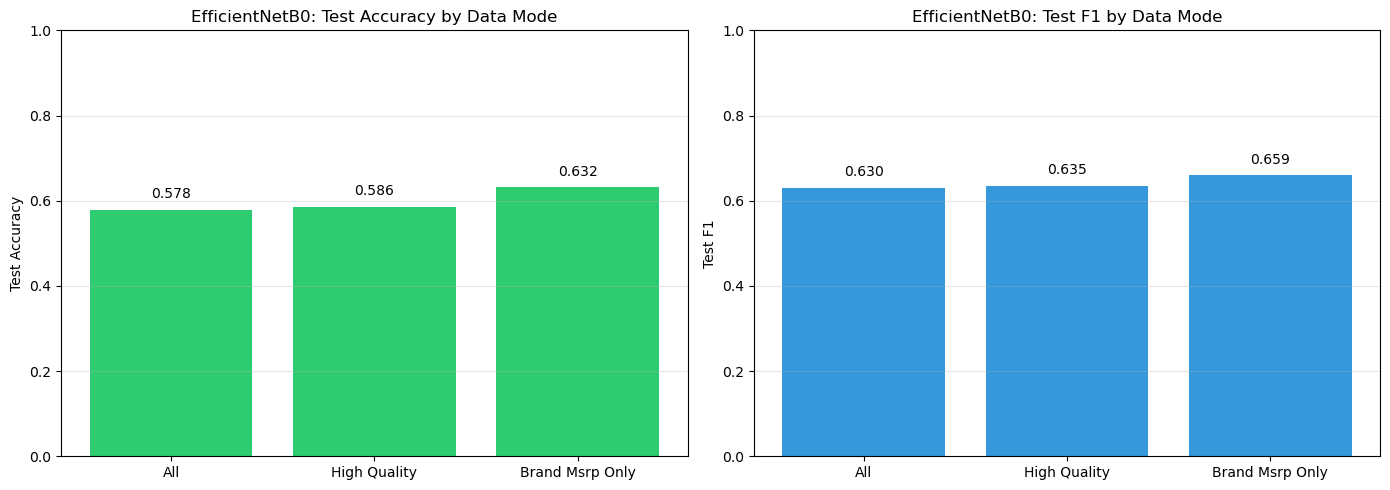

In [8]:
import matplotlib.pyplot as plt

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Data Mode': mode.replace('_', ' ').title(),
        'Train Size': results['train_samples'],
        'Test Accuracy': results['test_accuracy'],
        'Test F1': results['test_f1'],
        'Test Precision': results['test_precision'],
        'Test Recall': results['test_recall']
    }
    for mode, results in all_results.items()
])

print("\n" + "="*80)
print("EFFICIENTNETB0 RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics = ['Test Accuracy', 'Test F1']
colors = ['#2ecc71', '#3498db']
for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(comparison_df['Data Mode'], comparison_df[metric], color=color)
    ax.set_ylabel(metric)
    ax.set_title(f'EfficientNetB0: {metric} by Data Mode')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'efficientnet_comparison.png', dpi=300, bbox_inches='tight')
plt.show()